# Allgemeines

## Begriffe

Statistische Einheit
Grundgesamtheit
Stichprobe
Merkmal
Ausprägung

qualitativ und quantitativ
nominal ordinal diskret stetig


## Unvariante Statistik

1. Rohdatenanalyse graphisch und beschreibend
    - Scatterplot 
    - Zeitreihenanalyse (bspw. Durchschnitt über mehrere Jahre)
        - Trend, Saisonalität, Rauschen
        - gleitender Mittelwert
2. Absolute und relative Häufigkeit
    - Histogram: Wochentage oder Monatstage mit Anzahl als Histogram
    - empirische Verteilungsfunktion
3. Statistische Kennzahlen
    - Median
    - Boxplot
    - Violin-Plot

## Multivariante Statistik

1. Scatterplot auf 2 Achsen
2. Korrelation
    - Scatterplot / Heatmap
3. Lineare Regression
4. Vorhersage


In [140]:
import requests, re, os
from urllib.parse import urljoin, unquote
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import scipy
import seaborn as sns

# Load Data

In [141]:
herose_pattern = '.*Zaehlstelle_Heros(e|é)_[0-9]{4}_(stuendlich|taeglich)_Wetter.*.csv'
konstanz_data_portal_url = 'https://offenedaten-konstanz.de/dataset/fahrrad-dauerz-hlstellen'

req = requests.get(konstanz_data_portal_url)
soup = BeautifulSoup(req.text, "html.parser")
links = [urljoin(konstanz_data_portal_url, a["href"]) for a in soup.find_all("a", href=True) if
         a["href"].lower().endswith(".csv")]

data_dir = './data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

for link in links:
    path = f"./data/{unquote(link.rsplit("/", 1)[-1])}"

    if re.match(herose_pattern, path) and not os.path.exists(path.replace('é', 'e')):
        path = path.replace('é', 'e')

        try:
            csv_data = requests.get(link)
            print(f'Downloading to {path}')
        except requests.RequestException as e:
            print(f"failed to fetch {konstanz_data_portal_url}: {e}")
            continue

        with open(path, 'wb') as file:
            file.write(csv_data.content)
    else:
        print(f'{path} already downloaded.')

./data/Zaehlstelle_Herose_2018_stuendlich_4.csv alread downliaded.
./data/Zaehlstelle_Herose_2018_stuendlich_Wetter_5.csv alread downliaded.
./data/Zaehlstelle_Herose_2019_15min_2.csv alread downliaded.
./data/Zaehlstelle_Herose_2019_stuendlich_Wetter_4.csv alread downliaded.
./data/Zaehlstelle_Herose_2020_15min_3.csv alread downliaded.
./data/Zaehlstelle_Herose_2020_stuendlich_Wetter_4.csv alread downliaded.
./data/Zaehlstelle_Herose_2021_15min_3.csv alread downliaded.
./data/Zaehlstelle_Herose_2021_stuendlich_Wetter_5.csv alread downliaded.
./data/Zaehlstelle_Herose_2022_15min_2.csv alread downliaded.
./data/Zaehlstelle_Herose_2022_stuendlich_Wetter_3.csv alread downliaded.
./data/Zaehlstelle_Herosé_2023_15min.csv alread downliaded.
./data/Zaehlstelle_Herosé_2023_stuendlich_Wetter.csv alread downliaded.
./data/Zaehlstelle_Herosé_2023_taeglich_Wetter.csv alread downliaded.
./data/Zaehlstelle_Alte_Rheinbruecke_2023_15min.csv alread downliaded.
./data/Zaehlstelle_Alte_Rheinbruecke_2023_

## Load hourly Data

In [142]:
pattern = 'Zaehlstelle_Herose_[0-9]{4}_stuendlich_Wetter.*.csv'
files = [f'./data/{f}' for f in os.listdir("./data") if re.match(pattern, f)]

all_data_hourly = []
for f in files:
    time_amount_tmp = pd.read_csv(f, sep=';', engine='python')
    time_amount_tmp.columns = time_amount_tmp.columns.str.replace(r' \([^)]*\)', '', regex=True)
    all_data_hourly.append(time_amount_tmp)
all_data_hourly = pd.concat(all_data_hourly, ignore_index=True)


# postprocessing
all_data_hourly['date'] = pd.to_datetime(all_data_hourly['Zeit'], format="%d.%m.%Y %H:%M")

all_data_hourly = all_data_hourly.rename(columns={
    'Fahrradbruecke':'total_count',
    'Fahrradbruecke stadteinwaerts':'inbound_count',
    'Fahrradbruecke stadtauswaerts':'outbound_count',
    'Temperatur':'temperature',
    'Gefuehlte Temperatur':'feels_like_temperature',
    'Regen':'precipitation'
})

all_data_hourly = all_data_hourly[[
    'date',
    'total_count',
    'inbound_count',
    'outbound_count',
    'temperature',
    'feels_like_temperature',
    'precipitation'
]]

month_map = {'Jan': 1, 'Feb': 2, 'Mrz': 3, 'Apr': 4, 'Mai': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9}
regen_conv = []
for v in all_data_hourly['precipitation']:
    if isinstance(v, str) and '. ' in v:
        d, m = v.split('. ')
        regen_conv.append(float(f"{int(d)}.{month_map[m]}"))
    else:
        regen_conv.append(float(v))
all_data_hourly['precipitation'] = regen_conv

all_data_hourly.columns

Index(['date', 'total_count', 'inbound_count', 'outbound_count', 'temperature',
       'feels_like_temperature', 'precipitation'],
      dtype='object')

## Concat hourly data to daily

In [143]:
all_data_hourly['date'] = pd.to_datetime(all_data_hourly['date']).dt.date
all_data_daily_constructed = all_data_hourly.groupby('date').agg(
    total_count=('total_count','sum'),
    inbound_count=('inbound_count','sum'),
    outbound_count=('outbound_count','sum'),
    mean_temperature=('temperature','mean'),
    min_temperature=('temperature','min'),
    max_temperature=('temperature','max'),
    feels_like_temperature=('feels_like_temperature','mean'),
    precipitation=('precipitation','sum')
).reset_index()

all_data_daily_constructed[
    [
        'total_count',
        'inbound_count',
        'outbound_count',
        'precipitation'
    ]
] = (all_data_daily_constructed[
    [
        'total_count',
        'inbound_count',
        'outbound_count',
        'precipitation'
]].astype(int))

all_data_daily_constructed[
    [
        'mean_temperature',
        'feels_like_temperature'
    ]
] = (all_data_daily_constructed
     [
         [
             'mean_temperature',
             'feels_like_temperature'
         ]]*2).round()/2

all_data_daily_constructed

,date,total_count,inbound_count,outbound_count,mean_temperature,min_temperature,max_temperature,feels_like_temperature,precipitation
0,2018-08-08,8707,4195,4512,24.0,19.0,29.0,25.0,0
1,2018-08-09,8587,4019,4568,24.0,18.0,31.0,25.5,8
2,2018-08-10,8324,4084,4240,17.5,15.0,19.0,17.5,7
3,2018-08-11,11913,5474,6439,18.0,13.0,24.0,18.5,0
4,2018-08-12,7233,3353,3880,21.5,14.0,28.0,22.5,0
...,...,...,...,...,...,...,...,...,...
1967,2023-12-27,3953,0,0,3.5,2.0,7.0,3.5,0
1968,2023-12-28,4060,0,0,3.5,1.0,6.0,2.5,0
1969,2023-12-29,4965,0,0,6.0,4.0,9.0,4.0,0
1970,2023-12-30,4693,0,0,6.5,3.0,10.0,5.5,0


## Read daily 2023

In [144]:
daily_data_file = './data/Zaehlstelle_Herose_2023_taeglich_Wetter.csv'
all_data_daily = pd.read_csv(daily_data_file, sep=';', engine='python')
all_data_daily.columns = all_data_daily.columns.str.replace(r' \([^)]*\)', '', regex=True)

all_data_daily['date'] = pd.to_datetime(all_data_daily['Zeit'], format="%d.%m.%Y %H:%M").dt.date
all_data_daily = all_data_daily.drop(columns=['Zeit','Symbol Wetter','Quelle'])
all_data_daily = all_data_daily.rename(columns={
    'Fahrradbruecke':'total_count',
    'Fahrradbruecke stadteinwaerts Fahrraeder':'inbound_count',
    'Fahrradbruecke stadtauswaerts Fahrraeder':'outbound_count',
    'Temperatur':'mean_temperature',
    'Min. Temperatur':'min_temperature',
    'Max. Temperatur':'max_temperature',
    'Gefuehlte Temperatur':'feels_like_temperature',
    'Regen':'precipitation',
    'Schnee':'snow',
    'Wind':'wind',
    'Luftfeuchtigkeit':'humidity',
    'Wolken':'cloud_cover'
})
all_data_daily = all_data_daily[[
    'date',
    'total_count',
    'inbound_count',
    'outbound_count',
    'mean_temperature',
    'min_temperature',
    'max_temperature',
    'feels_like_temperature',
    'precipitation',
    'snow',
    'wind',
    'humidity',
    'cloud_cover'
]]

all_data_daily

,date,total_count,inbound_count,outbound_count,mean_temperature,min_temperature,max_temperature,feels_like_temperature,precipitation,snow,wind,humidity,cloud_cover
0,2023-01-01,2727,1275,1452,8.5,5,12,6,0.0,0.0,5,77,28
1,2023-01-02,4799,2363,2436,8.0,5,11,6,0.0,0.0,4,82,21
2,2023-01-03,4216,2052,2164,6.5,3,10,7,1.1,0.0,4,88,54
3,2023-01-04,5371,2658,2713,5.5,2,9,4,0.0,0.0,7,89,37
4,2023-01-05,5581,2711,2870,8.0,7,9,6,0.9,0.0,11,84,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-12-27,3953,1826,2127,4.5,2,7,3,0.0,0.0,2,74,31
361,2023-12-28,4060,1900,2160,3.5,1,6,3,0.0,0.0,5,66,48
362,2023-12-29,4965,2396,2569,6.5,4,9,4,0.0,0.0,8,75,53
363,2023-12-30,4693,2179,2514,6.5,3,10,5,0.2,0.0,6,84,34


# 1.Rohdatenanalyse
## 1.1 Plotten der Anzahl vs. Zeit

In [145]:
time_amount_tmp = all_data_daily_constructed.copy()
time_amount_tmp['dt'] = pd.to_datetime(time_amount_tmp['date'])
time_amount_tmp['month'] = time_amount_tmp['dt'].dt.month
time_amount_tmp['month_cont'] = (
        time_amount_tmp['month'] +
        (time_amount_tmp['dt'].dt.day - 1) / time_amount_tmp['dt'].dt.days_in_month
)
time_amount_tmp['year'] = time_amount_tmp['dt'].dt.year

time_amount_tmp

,date,total_count,inbound_count,outbound_count,mean_temperature,min_temperature,max_temperature,feels_like_temperature,precipitation,dt,month,month_cont,year
0,2018-08-08,8707,4195,4512,24.0,19.0,29.0,25.0,0,2018-08-08,8,8.225806,2018
1,2018-08-09,8587,4019,4568,24.0,18.0,31.0,25.5,8,2018-08-09,8,8.258065,2018
2,2018-08-10,8324,4084,4240,17.5,15.0,19.0,17.5,7,2018-08-10,8,8.290323,2018
3,2018-08-11,11913,5474,6439,18.0,13.0,24.0,18.5,0,2018-08-11,8,8.322581,2018
4,2018-08-12,7233,3353,3880,21.5,14.0,28.0,22.5,0,2018-08-12,8,8.354839,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,2023-12-27,3953,0,0,3.5,2.0,7.0,3.5,0,2023-12-27,12,12.838710,2023
1968,2023-12-28,4060,0,0,3.5,1.0,6.0,2.5,0,2023-12-28,12,12.870968,2023
1969,2023-12-29,4965,0,0,6.0,4.0,9.0,4.0,0,2023-12-29,12,12.903226,2023
1970,2023-12-30,4693,0,0,6.5,3.0,10.0,5.5,0,2023-12-30,12,12.935484,2023


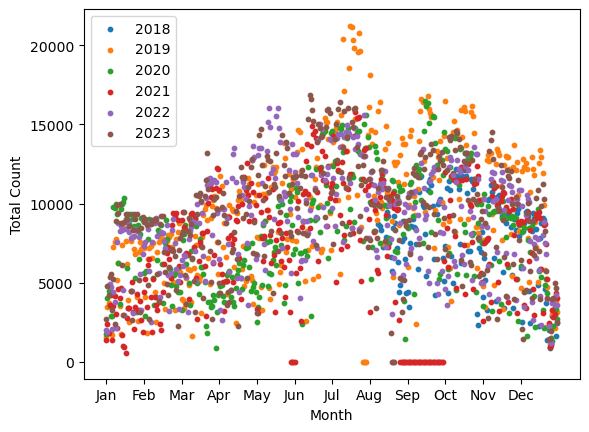

In [146]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('tab10')

for i, y in enumerate(sorted(time_amount_tmp['year'].unique())):
    d = time_amount_tmp[time_amount_tmp['year'] == y]
    ax.scatter(d['month_cont'], d['total_count'], label=str(y), color=cmap(i), s=10)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Total Count')
ax.legend()
plt.show()

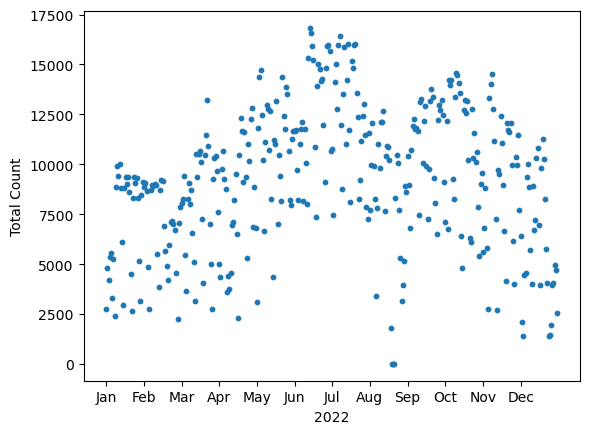

In [147]:
t2023 = time_amount_tmp[time_amount_tmp['year'] == 2023]
fig, ax = plt.subplots()
ax.scatter(t2023['month_cont'], t2023['total_count'], s=10)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('2022')
ax.set_ylabel('Total Count')
plt.show()

## 1.2 Zeitreihenanalyse

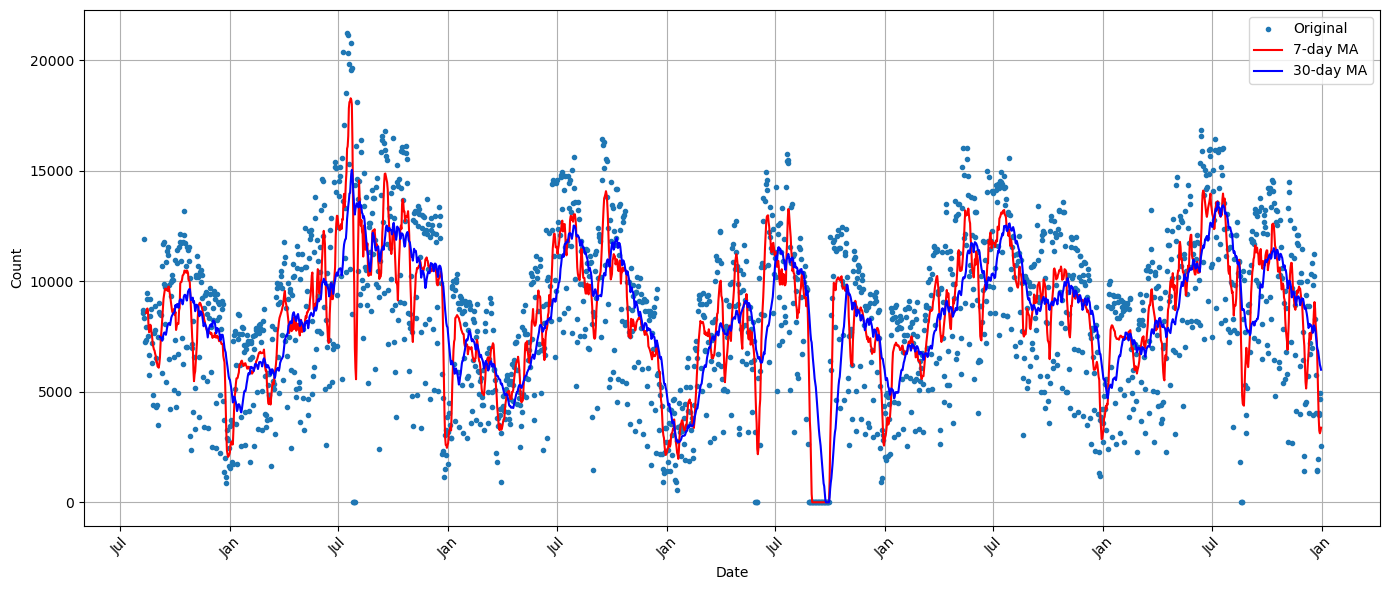

In [148]:
df = time_amount_tmp.sort_values('dt').set_index('dt')
df['ma_7'] = df['total_count'].rolling(7).mean()
df['ma_30'] = df['total_count'].rolling(30).mean()

plt.figure(figsize=(14,6))
plt.plot(df.index, df['total_count'], marker='o', linestyle='none', markersize=3, label='Original')
plt.plot(df.index, df['ma_7'], color='red', label='7-day MA')
plt.plot(df.index, df['ma_30'], color='blue', label='30-day MA')
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Absolute und Relative Häufigkeiten

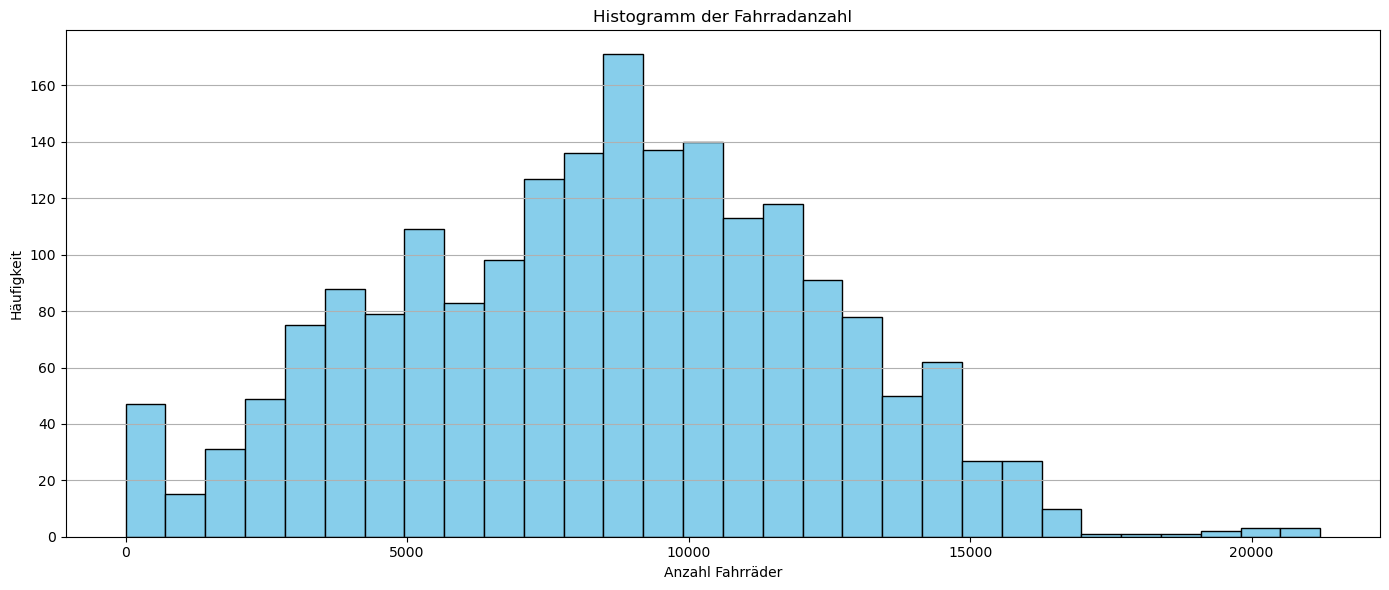

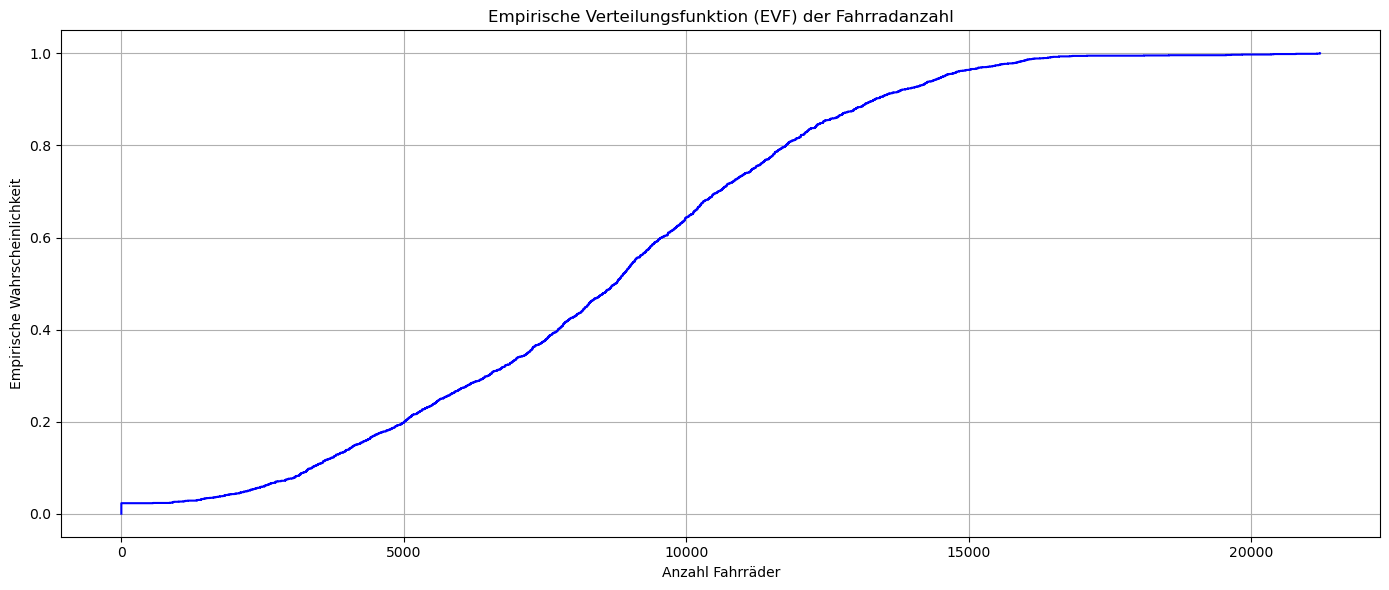

In [149]:
# Histogram
series = time_amount_tmp['total_count']

plt.figure(figsize=(14, 6))
plt.hist(series, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogramm der Fahrradanzahl')
plt.xlabel('Anzahl Fahrräder')
plt.ylabel('Häufigkeit')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Empirische Verteilungsfunktion
sorted_vals = series.sort_values().tolist()
n = len(sorted_vals)
y = [i/n for i in range(1, n+1)]

plt.figure(figsize=(14, 6))
plt.step(sorted_vals, y, where='post', color='blue')
plt.title('Empirische Verteilungsfunktion (EVF) der Fahrradanzahl')
plt.xlabel('Anzahl Fahrräder')
plt.ylabel('Empirische Wahrscheinlichkeit')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Statische Kennzahlen

Mean: 8492.993914807303
Median: 8745.5
Modalwert: 0
25%-Quantil: 5660.0
75%-Quantil: 11190.75
Standardabweichung: 3801.9841010958717
Varianz: 14455083.104985783


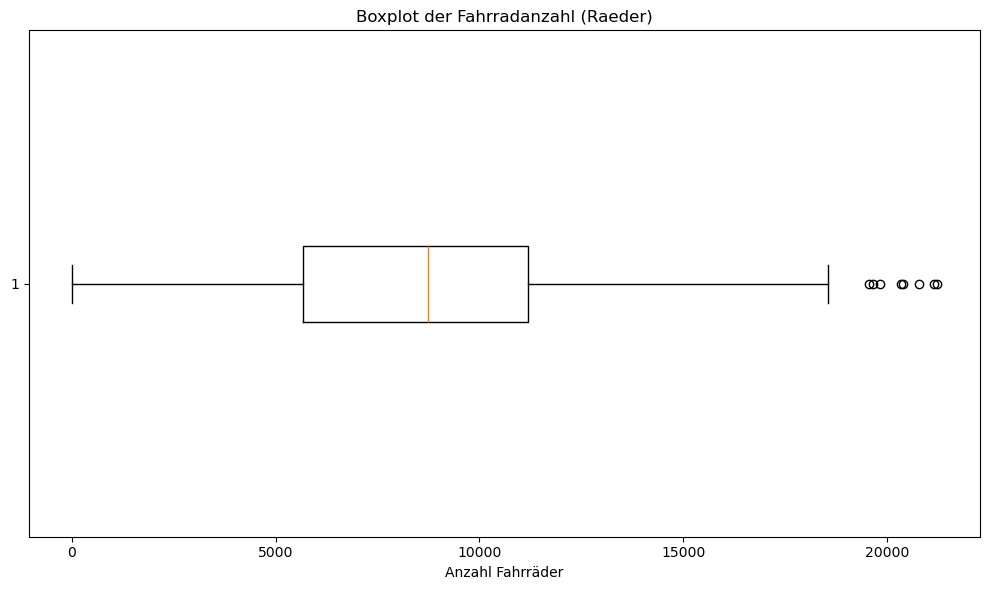

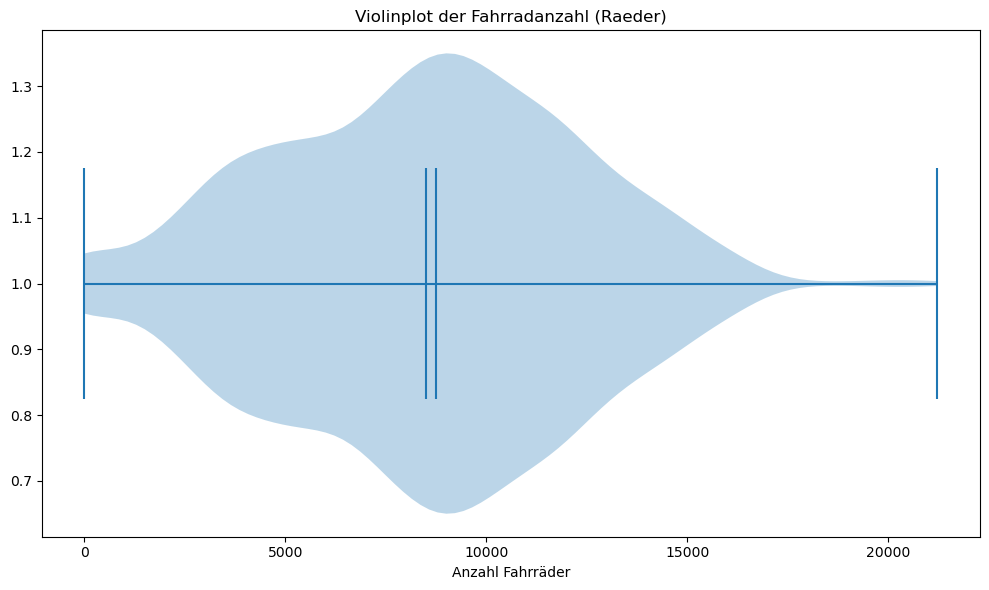

In [150]:
# Statistische Kennwerte berechnen
werte = np.array(time_amount_tmp['total_count'], dtype=float)

median = np.median(werte)
mean = np.mean(werte)
modalwert = np.bincount(werte.astype(int)).argmax()
quantile_25 = np.quantile(werte, 0.25)
quantile_75 = np.quantile(werte, 0.75)
standardabweichung = np.std(werte, ddof=1)
varianz = np.var(werte, ddof=1)

# Kennzahlen
print("Mean:", mean)
print("Median:", median)
print("Modalwert:", modalwert)
print("25%-Quantil:", quantile_25)
print("75%-Quantil:", quantile_75)
print("Standardabweichung:", standardabweichung)
print("Varianz:", varianz)

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(werte, vert=False)
plt.title('Boxplot der Fahrradanzahl (Raeder)')
plt.xlabel('Anzahl Fahrräder')
plt.tight_layout()
plt.show()

# Violin-Plot
plt.figure(figsize=(10, 6))
plt.violinplot(werte, vert=False, widths=0.7, showmeans=True, showmedians=True)
plt.title('Violinplot der Fahrradanzahl (Raeder)')
plt.xlabel('Anzahl Fahrräder')
plt.tight_layout()
plt.show()

# 3. Boxplots abhängig vom Wochentag

In [151]:
df_weekday = time_amount_tmp[['dt','total_count']].copy()
df_weekday['weekday'] = df_weekday['dt'].dt.weekday
grouped = [group['total_count'].values for _, group in df_weekday.groupby('weekday')]

correlation, _ = scipy.pearsonr(df_weekday['weekday'], df_weekday['total_count'])

plt.figure(figsize=(14,6))
plt.boxplot(grouped, positions=range(7), widths=0.6)
plt.xticks(range(7), ['Montag','Dienstag','Mittwoch','Donnerstag','Freitag','Samstag','Sonntag'])
plt.title('Räder pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Pearson Correlation zwischen Wochentag und Anzahl Räder:", correlation)

AttributeError: Module 'scipy' has no attribute 'pearsonr'

## Multivariante Statistik

1. Scatterplot auf 2 Achsen
2. Korrelation
    - Scatterplot / Heatmap
3. Lineare Regression
4. Vorhersage

In [127]:
# Korrelationsmatrix berechnen
corr = time_amount_tmp.corr(method='pearson')

# Heatmap plotten
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korrelationen')
plt.tight_layout()
plt.show()

# TODO LUKAS: Zusammenhang zwischen Regen und Rädern - ggf. Regenmenge oder Regen vs. kein Regen

TypeError: float() argument must be a string or a real number, not 'datetime.date'

# Zusammenhang von Temperatur und Rädern

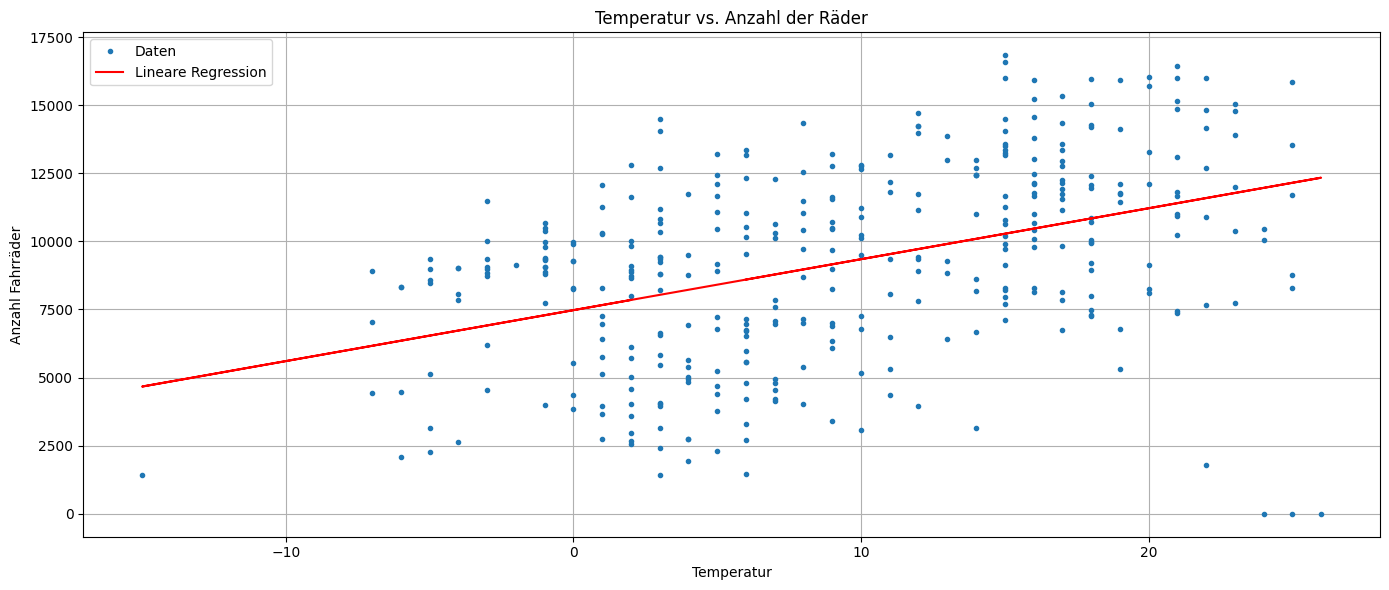

Pearson Correlation between Temperature and Raeder: 0.4258805266190003


In [82]:
# Pearson correlation
correlation, _ = pearsonr(temp, raeder)

# Linear regression
slope, intercept = np.polyfit(temp, raeder, 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(temp, raeder, marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(temp, regression_line(temp), color='red', label='Lineare Regression')
plt.title('Temperatur vs. Anzahl der Räder')
plt.xlabel('Temperatur')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Temperature and Raeder:", correlation)

# Zusammenhang von Regen und Rädern

[0.0, 0.0, 1.1, 0.0, 0.9, 0.0, 0.0, 0.1, 3.4, 0.3, 0.6, 1.5, 0.9, 0.2, 1.6, 0.0, 0.3, 0.8, 0.1, 1.0, 0.2, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.4, 3.9, 0.4, 0.0, 0.2, 0.8, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.3, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.8, 26.6, 9.3, 5.1, 6.0, 7.8, 14.2, 2.8, 0.0, 0.0, 0.0, 8.8, 0.0, 0.0, 0.0, 4.2, 9.6, 6.4, 12.6, 4.4, 0.0, 0.0, 9.8, 17.5, 9.8, 16.1, 1.8, 0.0, 0.0, 0.0, 30.2, 6.5, 0.5, 0.0, 3.4, 5.5, 3.0, 4.9, 0.1, 22.1, 5.7, 1.3, 6.0, 18.3, 1.5, 0.1, 13.0, 9.5, 13.0, 4.7, 0.1, 12.8, 3.7, 0.3, 1.4, 1.7, 0.0, 0.0, 1.4, 1.5, 9.0, 17.7, 12.6, 30.7, 2.2, 9.6, 0.2, 1.0, 4.4, 3.2, 0.1, 0.0, 0.0, 0.4, 7.1, 10.5, 8.2, 1.1, 0.9, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.1, 0.1, 0.6, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.8, 21.2, 1.5, 11.4, 0.2, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 24.9, 6.6, 0.3, 0.1, 3.5, 3.0, 0.1, 0.0, 0.0, 0.0, 0.8, 10.0, 16.5, 8.2, 0.0, 0.9

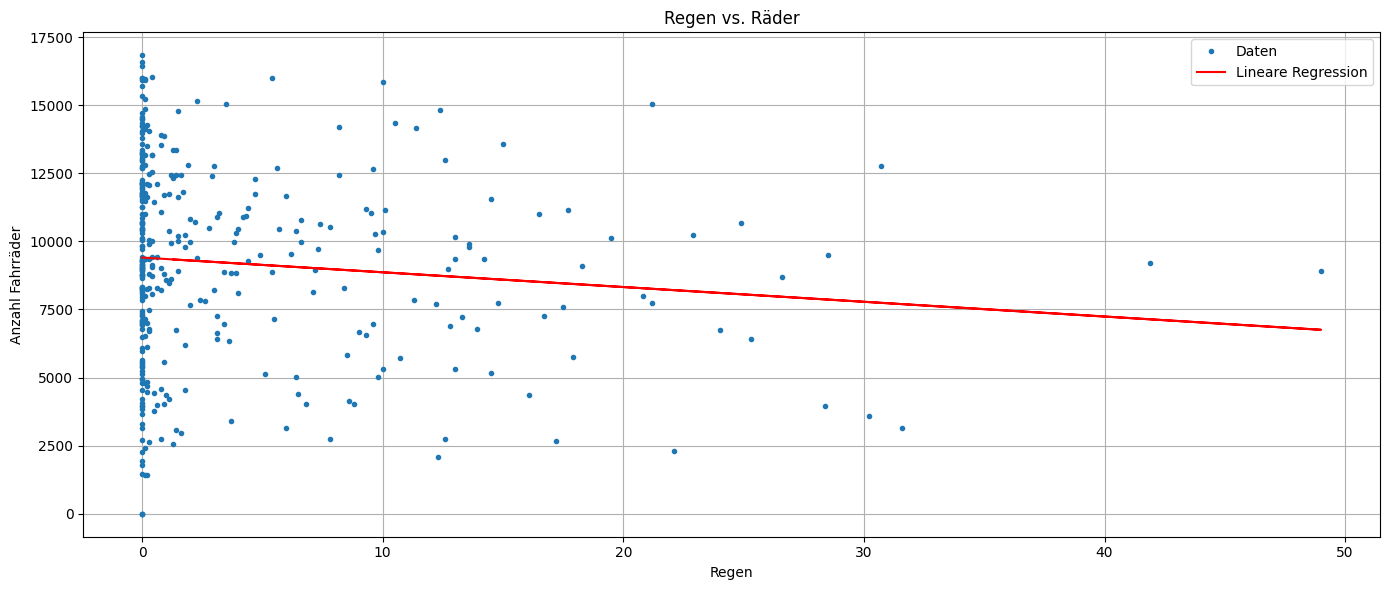

Pearson Correlation between Regen and Raeder: -0.10564860863985842


In [ ]:
# Pearson correlation
print(regen)
correlation, _ = pearsonr(regen, raeder)

# Linear regression
slope, intercept = np.polyfit(regen, raeder, 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(regen, raeder, marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(regen, regression_line(regen), color='red', label='Lineare Regression')
plt.title('Regen vs. Räder')
plt.xlabel('Regen')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Regen and Raeder:", correlation)

# Zusammenhang von Temperatur und Rädern

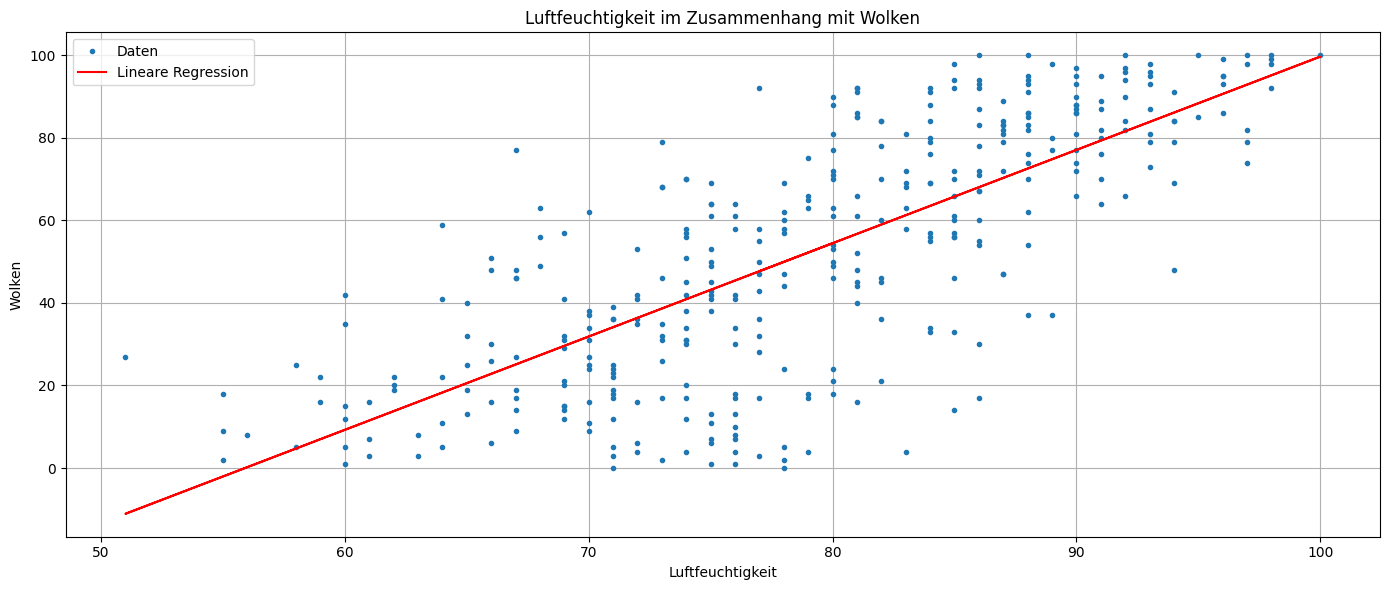

Pearson Correlation between Temperature and Raeder: 0.7481752147486931


In [81]:
# Pearson correlation
correlation, _ = pearsonr(luftfeuchtigkeit, wolken)

# Linear regression
slope, intercept = np.polyfit(luftfeuchtigkeit, wolken, 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(luftfeuchtigkeit, wolken, marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(luftfeuchtigkeit, regression_line(luftfeuchtigkeit), color='red', label='Lineare Regression')
plt.title('Luftfeuchtigkeit im Zusammenhang mit Wolken')
plt.xlabel('Luftfeuchtigkeit')
plt.ylabel('Wolken')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Temperature and Raeder:", correlation)